# Capstone : Default Risk Prediction Algorithm for Peer to Peer platform Investor

----------
# Contents:

## Modelling

1. [Importing Libraries](#1.-Importing-Libraries)
2. [Importing Data](#2.-Importing-Data)
3. [Data Cleaning](#3.-Data-Cleaning)
-------

In [248]:
pip install shap

  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
Note: you may need to restart the kernel to use updated packages.


In [176]:
import numpy as np
import pandas as pd
import shap
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
import pickle
from prettytable import PrettyTable
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
# sklearn: Import metrics.
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, f1_score, auc, precision_recall_curve, average_precision_score, RocCurveDisplay, ConfusionMatrixDisplay

## Loading the Data and Selecting the Features

<u>Loading data</u>

In [177]:
X_train = pd.read_csv('./data/x_train.csv', index_col = 0, low_memory=False)
y_train = pd.read_csv('./data/y_train.csv', index_col = 0, low_memory=False)
X_test = pd.read_csv('./data/x_test.csv', index_col = 0, low_memory=False)
y_test = pd.read_csv('./data/y_test.csv', index_col = 0, low_memory=False)

In [178]:
X_train.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-150K,annual_inc:>150K
235349,8000,36 months,6.49,245.16,A,A2,production adminstration,< 1 year,RENT,30000.0,...,0,0,0,0,0,0,0,0,0,0
258499,30000,60 months,11.99,667.19,B,B5,Sales,10+ years,MORTGAGE,132000.0,...,0,0,0,0,0,0,0,0,1,0
283665,8000,36 months,10.15,258.71,B,B2,NaN,NaN,MORTGAGE,25500.0,...,0,0,0,0,0,0,0,0,0,0
154664,14000,36 months,6.03,426.10,A,A1,OtherLevels,< 1 year,RENT,80000.0,...,0,0,0,0,1,0,0,0,0,0
159803,9950,36 months,14.33,341.67,C,C1,NaN,NaN,OWN,29000.0,...,0,0,0,0,0,0,0,0,0,0


In [179]:
y_train.head()

,target
235349,1
258499,1
283665,1
154664,1
159803,0


In [180]:
X_train.shape

(373028, 217)

In [181]:
y_train.shape

(373028, 1)

In [182]:
X_test.shape

(93257, 213)

In [183]:
y_test.shape

(93257, 1)

In [184]:
X_train['term:36'].head()

235349    1
258499    0
283665    1
154664    1
159803    1
Name: term:36, dtype: int64

In [185]:
# Here we select a limited set of input variables in a new dataframe.
inputs_train_with_ref_cat = X_train[['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'term:36',
'term:60',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',                                     
'initial_list_status:f',
'initial_list_status:w',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-150K',
'annual_inc:>150K',
]]

In [186]:
# Here we store the names of the reference category dummy variables in a list to be removed later explicitly to avoid the 
# dummy variable trap
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'term:60',
'dti:>35',
'int_rate:>20.281',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'delinq_2yrs:>=4',
'initial_list_status:f',
'emp_length:0',
'annual_inc:<20K']

In [187]:
inputs_train = inputs_train_with_ref_cat.drop(ref_categories, axis = 1)
# From the dataframe with input variables, we drop the variables with variable names in the list with reference categories. 
inputs_train.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,verification_status:Not Verified,verification_status:Source Verified,...,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-150K,annual_inc:>150K
235349,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
258499,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
283665,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
154664,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
159803,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [188]:
inputs_train_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,...,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-150K,annual_inc:>150K
235349,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
258499,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
283665,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
154664,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
159803,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
inputs_train_with_ref_cat.to_csv('./data/org_coded_train.csv')

In [190]:
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')

In [191]:
pd.options.display.max_rows = None

In [192]:
reg.fit(inputs_train, y_train.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=1000)

In [193]:
reg.intercept_

array([-2.95497462])

In [194]:
reg.coef_

array([[ 0.4819148 ,  0.61210406,  0.56331391,  0.48245807,  0.34265489,
         0.17536907,  0.15683661,  0.15314322,  0.09458289,  0.09622825,
         0.4814981 ,  0.36288778,  0.32071566,  0.39584356,  0.07681797,
        -0.18893792, -0.09018039, -0.02562082, -0.08895984, -0.14679519,
        -0.22948571, -0.2465868 , -0.3301068 , -0.2743402 ,  1.51289491,
         0.84952258,  0.49465528,  0.14283155,  1.26836319,  1.09638013,
         0.85537203,  0.02411488, -0.06301213, -0.03472339,  0.29925755,
         0.06199151,  0.0813311 ,  0.01515173,  0.04361746,  0.117371  ,
        -0.02111425,  0.0575123 ,  0.15835212,  0.2428441 ,  0.33451233,
         0.42449888,  0.49883083,  0.50361804,  0.58305838,  0.62723826,
         0.68056521]])

In [158]:
reg2 = LogisticRegression(max_iter=1000, class_weight = 'balanced')
pipeline = Pipeline([('ss', StandardScaler()), ('model', reg2)])

# define cross-validation criteria. RepeatedStratifiedKFold automatially takes care of the class imbalance while splitting
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

# fit and evaluate the logistic regression pipeline with cross-validation as defined in cv
scores = cross_val_score(pipeline, inputs_train, y_train.values.ravel(), scoring = 'roc_auc', cv = cv)
AUROC = np.mean(scores)

# print the mean AUROC score and Gini
print('Mean AUROC: %.4f' % (AUROC))

Mean AUROC: 0.6803


In [195]:
feature_name = inputs_train.columns.values

In [196]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
# Creates a dataframe with a column titled 'Feature name' and row values contained in the 'feature_name' variable.
summary_table['Coefficients'] = np.transpose(reg.coef_)
# Creates a new column in the dataframe, called 'Coefficients',
# with row values the transposed coefficients from the 'LogisticRegression' object.
summary_table.index = summary_table.index + 1
# Increases the index of every row of the dataframe with 1.
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
# Assigns values of the row with index 0 of the dataframe.
summary_table = summary_table.sort_index()
# Sorts the dataframe by index.
summary_table

,Feature name,Coefficients
0,Intercept,-2.954975
1,grade:A,0.481915
2,grade:B,0.612104
3,grade:C,0.563314
4,grade:D,0.482458
5,grade:E,0.342655
6,grade:F,0.175369
7,home_ownership:OWN,0.156837
8,home_ownership:MORTGAGE,0.153143
9,verification_status:Not Verified,0.094583


## Validation

In [197]:
# Here we select a limited set of input variables in a new dataframe.
inputs_test_with_ref_cat = X_test[['grade:A',
'grade:B',
'grade:C',
'grade:D',
'grade:E',
'grade:F',
'grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'home_ownership:OWN',
'home_ownership:MORTGAGE',
'verification_status:Not Verified',
'verification_status:Source Verified',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'purpose:credit_card',
'purpose:debt_consolidation',
'purpose:oth__med__vacation',
'purpose:major_purch__car__home_impr',
'term:36',
'term:60',
'dti:<=1.4',
'dti:1.4-3.5',
'dti:3.5-7.7',
'dti:7.7-10.5',
'dti:10.5-16.1',
'dti:16.1-20.3',
'dti:20.3-21.7',
'dti:21.7-22.4',
'dti:22.4-35',
'dti:>35',
'int_rate:<9.548',
'int_rate:9.548-12.025',
'int_rate:12.025-15.74',
'int_rate:15.74-20.281',
'int_rate:>20.281',
'inq_last_6mths:0',
'inq_last_6mths:1-2',
'inq_last_6mths:3-6',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'acc_now_delinq:>=1',
'delinq_2yrs:0',
'delinq_2yrs:1-3',
'delinq_2yrs:>=4',   
'initial_list_status:f',
'initial_list_status:w',
'emp_length:0',
'emp_length:1',
'emp_length:2-4',
'emp_length:5-6',
'emp_length:7-9',
'emp_length:10',
'annual_inc:<20K',
'annual_inc:20K-30K',
'annual_inc:30K-40K',
'annual_inc:40K-50K',
'annual_inc:50K-60K',
'annual_inc:60K-70K',
'annual_inc:70K-80K',
'annual_inc:80K-90K',
'annual_inc:90K-100K',
'annual_inc:100K-120K',
'annual_inc:120K-150K',
'annual_inc:>150K',
]]

In [198]:
# Here we store the names of the reference category dummy variables in a list to be removed later explicitly to avoid the 
# dummy variable trap
ref_categories = ['grade:G',
'home_ownership:RENT_OTHER_NONE_ANY',
'verification_status:Verified',
'purpose:educ__sm_b__wedd__ren_en__mov__house',
'term:60',
'dti:>35',
'int_rate:>20.281',
'inq_last_6mths:>6',
'acc_now_delinq:0',
'delinq_2yrs:>=4',
'initial_list_status:f',
'emp_length:0',
'annual_inc:<20K']

In [199]:
inputs_test = inputs_test_with_ref_cat.drop(ref_categories, axis = 1)
inputs_test.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,home_ownership:OWN,home_ownership:MORTGAGE,verification_status:Not Verified,verification_status:Source Verified,...,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-150K,annual_inc:>150K
283311,0,1,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
328182,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
389681,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
223572,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
242106,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [200]:
inputs_test_with_ref_cat.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,home_ownership:RENT_OTHER_NONE_ANY,home_ownership:OWN,home_ownership:MORTGAGE,...,annual_inc:30K-40K,annual_inc:40K-50K,annual_inc:50K-60K,annual_inc:60K-70K,annual_inc:70K-80K,annual_inc:80K-90K,annual_inc:90K-100K,annual_inc:100K-120K,annual_inc:120K-150K,annual_inc:>150K
283311,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
328182,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
389681,0,1,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
223572,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
242106,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [201]:
inputs_test_with_ref_cat.to_csv('./data/org_coded_test.csv')

In [202]:
y_pred = reg.predict(inputs_test)

In [203]:
# Generate confusion matrix.
cm = confusion_matrix(y_test.values.ravel(), y_pred)  # True vs Predicted values.
cm

array([[ 6624,  3570],
       [32875, 50188]], dtype=int64)

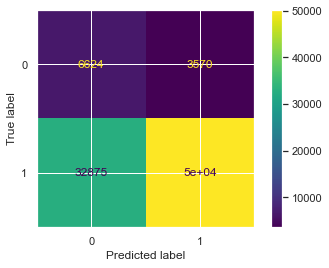

In [204]:
sns.set()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
disp.plot();

In [205]:
def get_predictions(pred_proba, threshold): # define custom function to accept 2 args, prediction probabilities & threshold
    return [0 if prob < threshold else 1 for prob in pred_proba] # list comprehension to return custom threshold based on probability

Threshold: 0.25, Recall score: 0.9803763408497165
Threshold: 0.25, Precision score: 0.8946813302717015
Threshold: 0.4, Recall score: 0.8108544117115924
Threshold: 0.4, Precision score: 0.9165407906375451
Threshold: 0.5, Recall score: 0.6042160769536375
Threshold: 0.5, Precision score: 0.9335912794374791
Threshold: 0.6, Recall score: 0.3794830429914643
Threshold: 0.6, Precision score: 0.9502577552681559
Threshold: 0.75, Recall score: 0.1327185389403224
Threshold: 0.75, Precision score: 0.9735935706084959


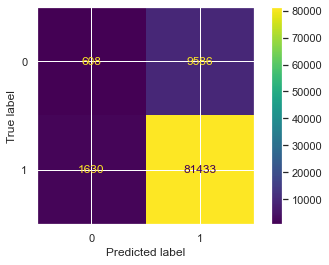

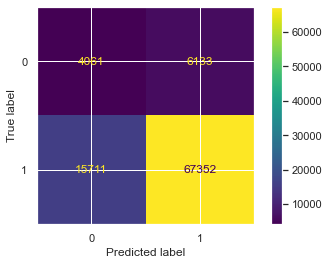

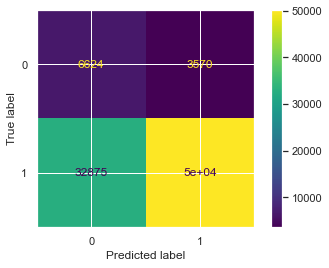

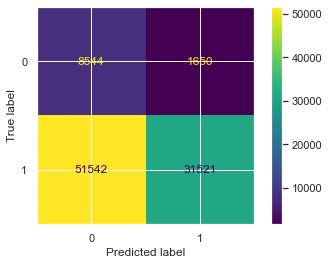

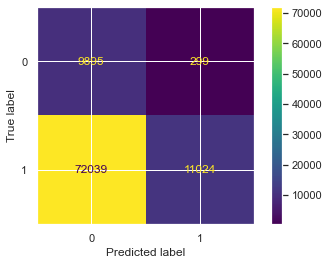

In [206]:
# simulating experiment with a few thresholds to trial optimal score for model 
threshold_list = [0.25, 0.4, 0.5, 0.6, 0.75]

for threshold in threshold_list:
    preds = get_predictions(pred_proba=reg.predict_proba(inputs_test)[:,1], threshold=threshold) # get predictions based on custom threshold
    rc = recall_score(y_test, preds) # with the preds from different custom thresholds, compare model effectiveness vs actual y_test
    print(f'Threshold: {threshold}, Recall score: {rc}')
    precision = precision_score(y_test, preds)
    print(f'Threshold: {threshold}, Precision score: {precision}')
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['0', '1'])
    disp.plot();

Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.


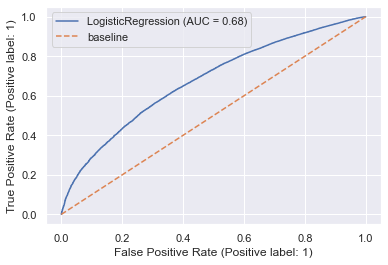

In [207]:
# from sklearn metrics
sns.set()
plot_roc_curve(reg, inputs_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--') # to simulate random guess 
plt.legend();

<u>Export relevant files for model evaluation in next notebook:</u>

In [208]:
pickle.dump(reg, open("./data/log_reg.pickle.dat", "wb"))

In [209]:
inputs_train.to_csv('./data/model_train.csv')
y_train.to_csv('./data/model_y_train.csv')
inputs_test.to_csv('./data/model_test.csv')
y_test.to_csv('./data/model_y_test.csv')

<u>Brief evaluation of other modelling approach like Random Classfier & XGBoost</u>

I won't be doing any comparison here because the main focus of the project is to build a credit scorecard as described earlier and only linear model like logistic regression would be used.

In [210]:
X_train.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       ...
       'annual_inc:30K-40K', 'annual_inc:40K-50K', 'annual_inc:50K-60K',
       'annual_inc:60K-70K', 'annual_inc:70K-80K', 'annual_inc:80K-90K',
       'annual_inc:90K-100K', 'annual_inc:100K-120K', 'annual_inc:120K-150K',
       'annual_inc:>150K'],
      dtype='object', length=217)

In [211]:
# Using the same features used to train Logistic Regression
inputs_train_other = X_train[['grade',
'home_ownership',
'verification_status',
'purpose',
'term',
'dti'
]]

In [212]:
inputs_train_other.head()

,grade,home_ownership,verification_status,purpose,term,dti
235349,A,RENT,Not Verified,major_purchase,36 months,27.44
258499,B,MORTGAGE,Source Verified,debt_consolidation,60 months,15.23
283665,B,MORTGAGE,Verified,debt_consolidation,36 months,4.99
154664,A,RENT,Source Verified,credit_card,36 months,14.77
159803,C,OWN,Verified,debt_consolidation,36 months,15.56


In [213]:
train_process = inputs_train_other.copy()

In [214]:
train_process.head()

,grade,home_ownership,verification_status,purpose,term,dti
235349,A,RENT,Not Verified,major_purchase,36 months,27.44
258499,B,MORTGAGE,Source Verified,debt_consolidation,60 months,15.23
283665,B,MORTGAGE,Verified,debt_consolidation,36 months,4.99
154664,A,RENT,Source Verified,credit_card,36 months,14.77
159803,C,OWN,Verified,debt_consolidation,36 months,15.56


In [215]:
train_process.shape

(373028, 6)

In [216]:
# Using the same features used to test Logistic Regression
inputs_test_other = X_test[['grade',
'home_ownership',
'verification_status',
'purpose',
'term',
'dti'
]]

In [217]:
test_process = inputs_test_other.copy()

In [218]:
test_process.shape

(93257, 6)

In [219]:
train_process['train'] = 1
test_process['train'] = 0
combine = pd.concat([train_process, test_process])

In [220]:
combine.shape

(466285, 7)

In [221]:
df = pd.get_dummies(combine, columns=['grade', 'home_ownership', 'verification_status', 'purpose', 'term'])

In [222]:
df.head()

,dti,train,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
235349,27.44,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
258499,15.23,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
283665,4.99,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
154664,14.77,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
159803,15.56,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [223]:
train_back = df[df['train'] == 1]
test_back = df[df['train'] == 0]

In [224]:
train_back.shape

(373028, 34)

In [225]:
train_back.drop('train', inplace=True, axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [226]:
train_back.shape

(373028, 33)

In [227]:
train_process = train_back
train_process.head()

,dti,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
235349,27.44,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
258499,15.23,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
283665,4.99,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
154664,14.77,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
159803,15.56,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [228]:
test_back.shape

(93257, 34)

In [229]:
test_back.drop('train', inplace=True, axis=1)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [230]:
test_back.shape

(93257, 33)

In [231]:
test_process = test_back
test_process.head()

,dti,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,home_ownership_ANY,home_ownership_MORTGAGE,...,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
283311,24.06,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
328182,22.04,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
389681,10.18,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
223572,27.36,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
242106,30.89,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [232]:
# Instiantiate models

models = {'rf': RandomForestClassifier(random_state=42),
          'xgb' : XGBClassifier(random_state=42, use_label_encoder = False, eval_metric='mlogloss'),
          'ada': AdaBoostClassifier(random_state=42)}

In [233]:
# Create a PrettyTable to store overall summary of model performance without hyperparameter tuning

summary = PrettyTable(['Model', 'Train AUC', 'Test AUC', 'Precision', 'Specificity', 'Recall', 'F1_score'])


# Create a PrettyTable to store overall summary of model performance with hyperparameter tuning

summary_tuning = PrettyTable(['Model', 'Train AUC', 'Test AUC', 'Precision', 'Specificity', 'Recall', 'F1_score'])

In [234]:
# Define a function to run model -- input vectorizer and model

def run_model(model, title, model_params = {}, grid_search = False):
        
    # Create a PrettyTable for individual model
    indv = PrettyTable(['Model', 'Train AUC', 'Test AUC', 'Precision', 'Specificity', 'Recall', 'F1_score'])
    
    # Set up pipeline with two stages: 
    # 1. Scale 
    # 2. Model 
    pipe = Pipeline([
                    ('ss', StandardScaler()),
                     (model, models[model])
                    ])
    
    if grid_search == True:
        model_gs = GridSearchCV(pipe, param_grid = model_params, cv = 10, verbose = 1, scoring='roc_auc', n_jobs = -1)
        model_gs.fit(train_process, y_train.values.ravel())
        pipe = model_gs
        
    else:
        pipe.fit(train_process, y_train.values.ravel())
        
    
    # Get predictions
    y_preds = pipe.predict(test_process)
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
    y_test_pred_prob = pipe.predict_proba(test_process)[:,1]
    y_train_pred_prob = pipe.predict_proba(train_process)[:,1]
    
    # Get ROC, Precision, Specificity, Recall & F1_score
    train_roc =  round(roc_auc_score(y_train, y_train_pred_prob),4)
    test_roc =  round(roc_auc_score(y_test, y_test_pred_prob),4)
    precision =  round(precision_score(y_test, y_preds),4)
    specificity =  round(tn / (tn + fp),4)
    recall =  round(recall_score(y_test, y_preds),4)
    f_score =  round(f1_score(y_test, y_preds),4)
    
    # Add the model performance to indv PrettyTable
    indv.add_row([models[model], train_roc, test_roc, precision, specificity, recall, f_score])
    display(indv)
    
    # Add the model performance to overall summary PrettyTable
    if grid_search == True:
        summary_tuning.add_row([models[model], train_roc, test_roc, precision, specificity, recall, f_score])
        print("------------------------------------------------------")
        print('\033[1m'+'\033[4m'+"Best Hyperparameter"+'\033[0m'+'\033[0m')
        display(pipe.best_params_)
    
    else:
        summary.add_row([models[model], train_roc, test_roc, precision, specificity, recall, f_score])
        
    # View confusion matrix 
    print("------------------------------------------------------")
    print('\033[1m'+'\033[4m'+"\nConfusion Matrix"+'\033[0m'+'\033[0m')
    ConfusionMatrixDisplay.from_estimator(pipe, test_process, y_test, cmap = 'Blues', values_format = 'd')
    plt.title(title)
    plt.show()
    
    print(f"\nTrue Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}\n")
    print("------------------------------------------------------")
    print('\033[1m'+'\033[4m'+"Classification Report"+'\033[0m'+'\033[0m')
    print(classification_report(y_test, y_preds))

    return pipe

Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
RandomForestClassifier(random_state=42),0.978,0.559,0.894,0.1086,0.9231,0.9083


------------------------------------------------------

Confusion Matrix


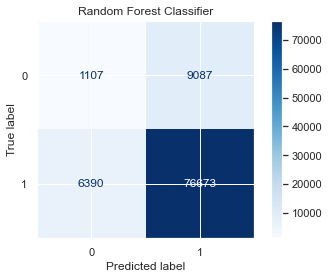


True Negatives: 1107
False Positives: 9087
False Negatives: 6390
True Positives: 76673

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.15      0.11      0.13     10194
           1       0.89      0.92      0.91     83063

    accuracy                           0.83     93257
   macro avg       0.52      0.52      0.52     93257
weighted avg       0.81      0.83      0.82     93257



In [235]:
# Run the model - Random Forest Classifier

rf = run_model('rf', 'Random Forest Classifier')

Model,Train AUC,Test AUC,Precision,Specificity,Recall,F1_score
"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, enable_categorical=False, eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None, interaction_constraints='', learning_rate=0.300000012, max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact', use_label_encoder=False, validate_parameters=1, verbosity=None)",0.6913,0.6523,0.8907,0.0005,0.9998,0.9421


------------------------------------------------------

Confusion Matrix


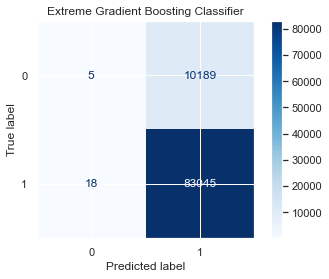


True Negatives: 5
False Positives: 10189
False Negatives: 18
True Positives: 83045

------------------------------------------------------
Classification Report
              precision    recall  f1-score   support

           0       0.22      0.00      0.00     10194
           1       0.89      1.00      0.94     83063

    accuracy                           0.89     93257
   macro avg       0.55      0.50      0.47     93257
weighted avg       0.82      0.89      0.84     93257



In [236]:
# Run the model - Extreme Gradient Boosting Classifier

xgb = run_model('xgb', 'Extreme Gradient Boosting Classifier')